In [35]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, rank, desc, sum, max, round
from pyspark.sql import Window
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("last-year-top-spending-customers").getOrCreate()

22/08/22 12:51:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
orders_df = spark.read.option("inferSchema", "True").option("header", "true") \
                      .csv("/home/jovyan/work/notebooks/ecommerce_data/olist_orders_dataset.csv")
customers_df = spark.read.option("inferSchema", "True").option("header", "true") \
                         .csv("/home/jovyan/work/notebooks/ecommerce_data/olist_customers_dataset.csv")
payments_df = spark.read.option("inferSchema", "True").option("header", "true") \
                        .csv("/home/jovyan/work/notebooks/ecommerce_data/olist_order_payments_dataset.csv")

In [43]:
df = orders_df.agg(max(year("order_approved_at")).alias("a"))
n = df.toPandas().to_string()
last_year = int(n[11:15]) - 1
window = Window.partitionBy("month").orderBy(desc("total"))
df10 = orders_df.join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
                .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
                .filter(year("order_approved_at") == last_year) \
                .groupBy(["customer_unique_id", month("order_approved_at").alias("month")]) \
                .agg(sum("payment_value").alias("total")).orderBy(desc("total")).withColumn("rank", rank().over(window)) \
                .filter(col('rank') == 1).select("customer_unique_id", "month", round("total", 2)).orderBy("month")

In [37]:
path = "/home/jovyan/work/notebooks/ecommerce_data"

In [44]:
df10.toPandas()

+--------------------+-----+---------------+
|  customer_unique_id|month|round(total, 2)|
+--------------------+-----+---------------+
|ee2bb06c1d3f368e9...|    1|        3016.01|
|dc4802a71eae9be1d...|    2|        6929.31|
|011875f0176909c5c...|    3|        4016.91|
|da122df9eeddfedc1...|    4|        7571.63|
|ff4159b92c40ebe40...|    5|        6726.66|
|ff0ae98646e7bbb41...|    6|        3048.27|
|6172bd5b7f52ade8c...|    7|        3041.73|
|60b2ec19b8c18082c...|    8|        2692.82|
|58c1b085b54c03a1f...|    9|        3064.72|
|0a0a92112bd4c708c...|   10|       13664.08|
|4007669dec559734d...|   11|        6081.54|
|7a96eb0a685f5c19b...|   12|         3297.4|
+--------------------+-----+---------------+



In [7]:
data = [int(i * 100) / 100 for i in df10.select("total").orderBy(desc("month")).rdd.flatMap(lambda x: x).collect()]
cust = df10.select("customer_unique_id").orderBy(desc("month")).rdd.flatMap(lambda x: x).collect()
months = ['December', 'November', 'October', 'September',  'August', 'July', 
          'June', 'May',  'April', 'March', 'February', 'January']

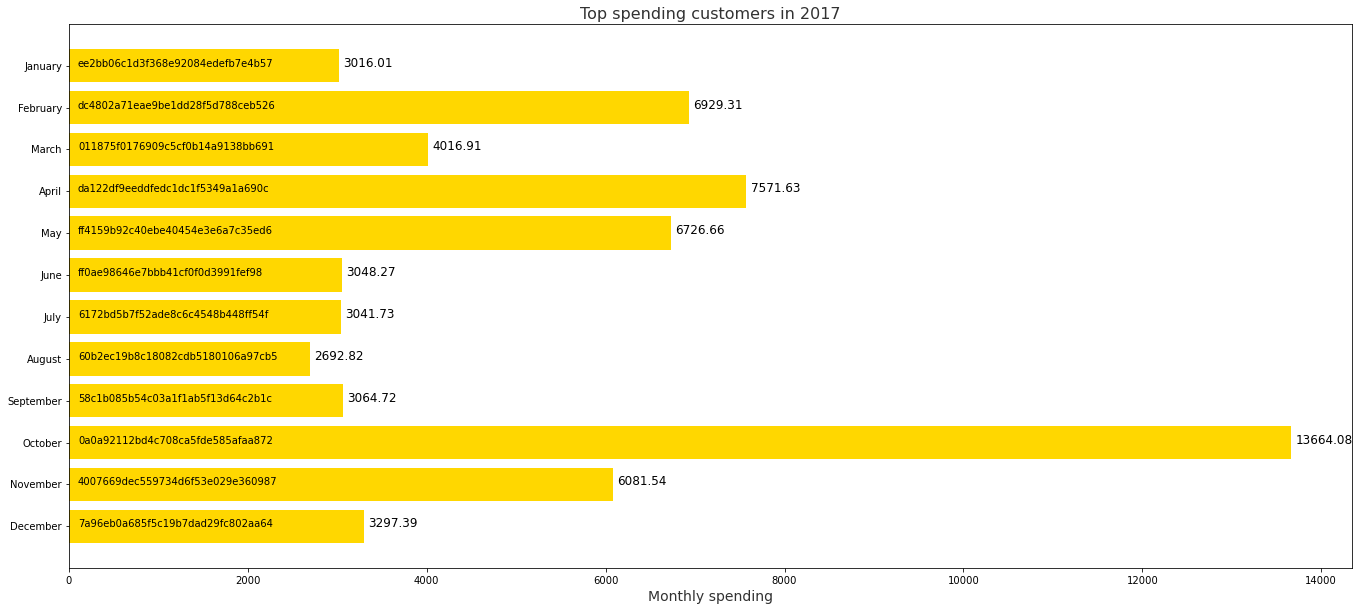

In [8]:
y_pos = np.arange(len(data))
 
plt.figure(figsize=(23,10))
 
plt.barh(y_pos, data, color = 'gold')

plt.yticks(y_pos, months, va="center")
 
plt.xlabel('Monthly spending', fontsize=14, color='#323232')
plt.title('Top spending customers in ' + str(last_year), fontsize=16, color='#323232')

for i in range(len(cust)):
    plt.text(100, i, cust[i], color = "black", fontsize = 10)
    plt.text(data[i] + 50, i, data[i], color = "black", fontsize = 12)
##
# plt.show()
plt.savefig(path + "/plot_1.png")

In [9]:
df11 = orders_df.join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
                .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
                .filter(year("order_approved_at") == last_year) \
                .groupBy([month("order_approved_at").alias("month")]) \
                .agg(sum("payment_value").alias("total")).orderBy(desc("total")).withColumn("rank", rank().over(window)) \
                .filter(col('rank') == 1).select("month", "total").orderBy("month")

In [10]:
df11.toPandas()

,month,total
0,1,131835.87
1,2,291836.22
2,3,446020.61
3,4,413537.47
4,5,593119.02
5,6,515293.57
6,7,585260.30
7,8,672772.79
8,9,717821.79
9,10,782898.61


In [11]:
data_2 = [int(i * 100) / 100 for i in df11.select("total").orderBy(desc("month")).rdd.flatMap(lambda x: x).collect()]

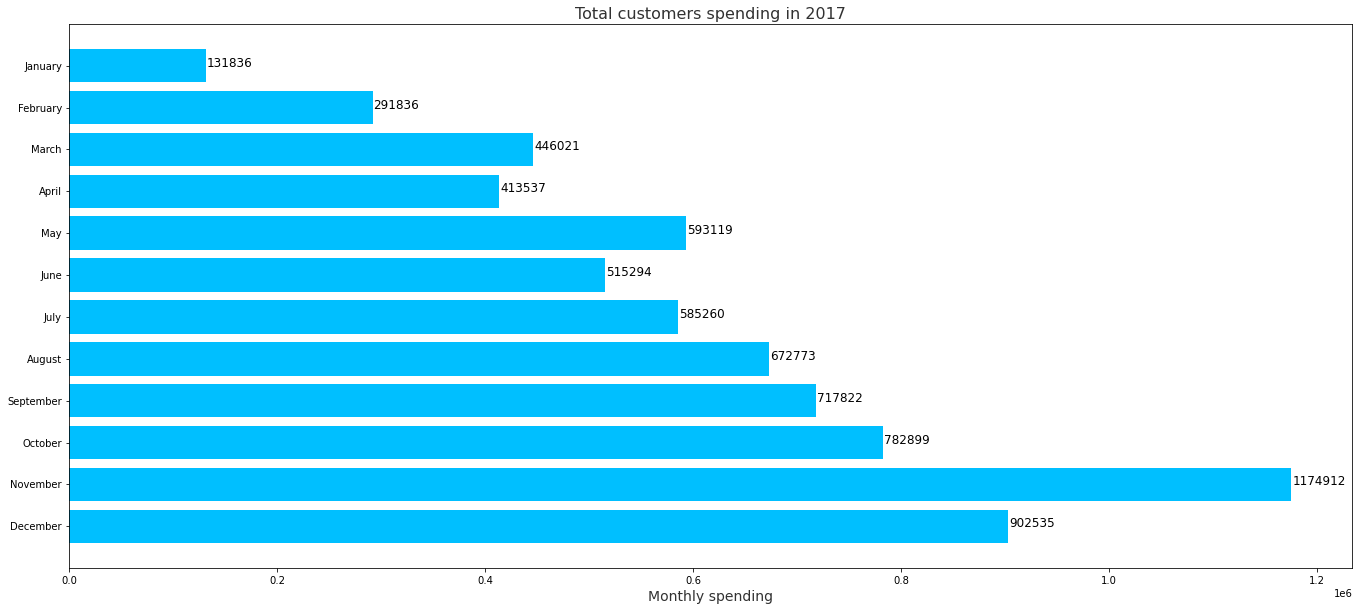

In [12]:
y_pos = np.arange(len(data_2))
 
plt.figure(figsize=(23, 10))
 
plt.barh(y_pos, data_2, color = 'deepskyblue')

plt.yticks(y_pos, months, va="center")
 
plt.xlabel('Monthly spending', fontsize=14, color='#323232')
plt.title('Total customers spending in ' + str(last_year), fontsize=16, color='#323232')

for i in range(len(data_2)):
#     plt.text(100, i, cust[i], color = "black", fontsize = 10)
    plt.text(1000 + data_2[i], i, round(data_2[i]), color = "black", fontsize = 12)
##
# plt.show()
plt.savefig(path + "/plot_2.png")

In [13]:
window_2 = Window.partitionBy().orderBy(desc("total"))
df12 = orders_df.join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
                .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
                .filter(year("order_approved_at") == last_year) \
                .groupBy("customer_unique_id") \
                .agg(sum("payment_value").alias("total")).orderBy(desc("total")).withColumn("rank", rank().over(window_2)) \
                .filter(col("rank") <= 10).orderBy(desc("total")).select("rank", "customer_unique_id", "total")

In [14]:
df12.toPandas()

22/08/22 12:54:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,rank,customer_unique_id,total
0,1,0a0a92112bd4c708ca5fde585afaa872,13664.08
1,2,da122df9eeddfedc1dc1f5349a1a690c,7571.63
2,3,dc4802a71eae9be1dd28f5d788ceb526,6929.31
3,4,ff4159b92c40ebe40454e3e6a7c35ed6,6726.66
4,5,4007669dec559734d6f53e029e360987,6081.54
5,6,eebb5dda148d3893cdaf5b5ca3040ccb,4764.34
6,7,edf81e1f3070b9dac83ec83dacdbb9bc,4194.76
7,8,055ec572ac7f3c7bdd04a183830ebe59,4053.08
8,9,5e713be0853d8986528d7869a0811d2b,4042.74
9,10,011875f0176909c5cf0b14a9138bb691,4016.91


In [15]:
data_3 = [int(i * 100) / 100 for i in df12.select("total").orderBy("total").rdd.flatMap(lambda x: x).collect()]
cust = df12.select("customer_unique_id").orderBy(desc("total")).rdd.flatMap(lambda x: x).collect()

22/08/22 12:54:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/22 12:54:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


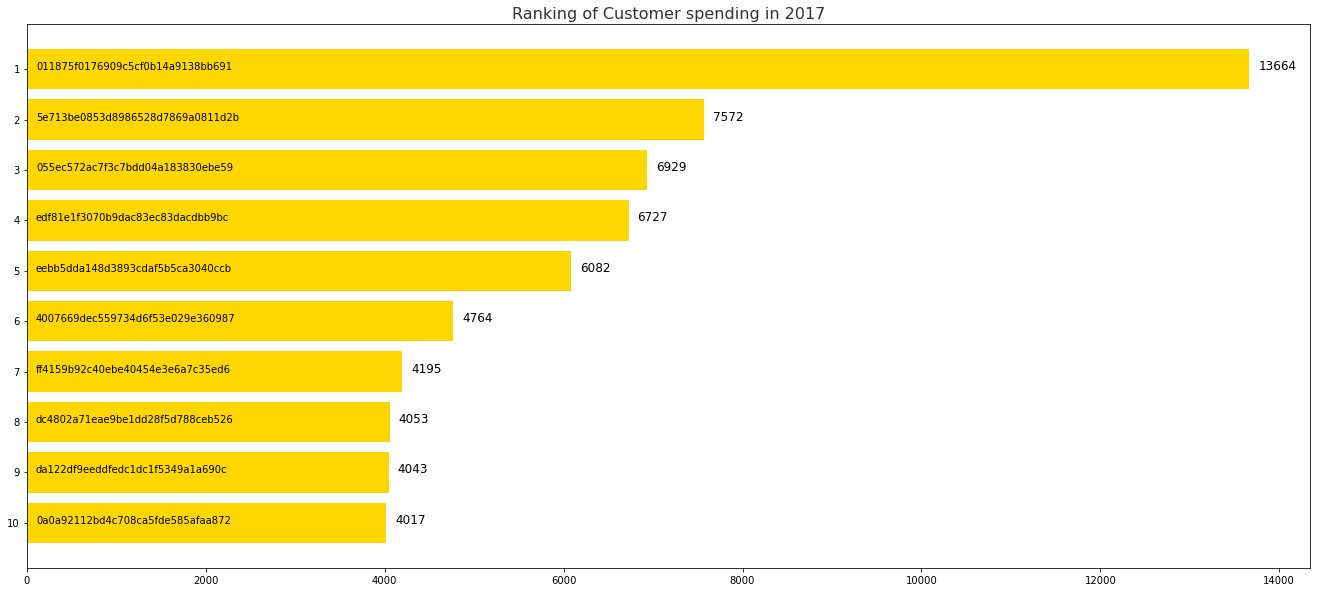

In [16]:
y_pos = np.arange(len(data_3))
 
plt.figure(figsize=(23, 10))
 
plt.barh(y_pos, data_3, color = 'gold')

plt.yticks(y_pos, [i for i in range(10, 0, -1)], va="center")
 
# plt.xlabel('Whole year spending', fontsize=14, color='#323232')
plt.title('Ranking of Customer spending in ' + str(last_year), fontsize=16, color='#323232')

for i in range(len(data_3)):
    plt.text(100, i, cust[i], color = "black", fontsize = 10)
    plt.text(100 + data_3[i], i, round(data_3[i]), color = "black", fontsize = 12)
##
# plt.show()
plt.savefig(path + "/plot_3.png")

In [17]:
pip install fpdf

Note: you may need to restart the kernel to use updated packages.


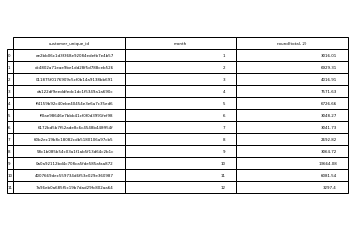

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table

ax = plt.subplot(111) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)
# panda.plot(figsize=(8,3));
ax.plot(figsize=(30, 10))
table(ax, df10.toPandas(), loc='center')  # where df is your data frame

plt.savefig('mytable.png')
# plt.show()

In [19]:
from fpdf import FPDF
class PDF(FPDF):
    def __init__(self):
        super().__init__()
        self.WIDTH = 210
        self.HEIGHT = 297
        
    def header(self):
        # Custom logo and positioning
        # Create an `assets` folder and put any wide and short image inside
        # Name the image `logo.png`
#         self.image('assets/logo.png', 10, 8, 33)
        self.set_font('Arial', 'B', 11)
        self.cell(self.WIDTH - 80)
        self.cell(60, 1, 'Costumer Spendings report', 0, 0, 'R')
        self.ln(20)
        
    def footer(self):
        # Page numbers in the footer
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.set_text_color(128)
        self.cell(0, 10, 'Page ' + str(self.page_no()), 0, 0, 'C')

    def page_body(self, images):
        # Determine how many plots there are per page and set positions
        # and margins accordingly
        if len(images) == 3:
            self.image(images[0], 0, 25, self.WIDTH)
            self.image(images[1], 0, self.WIDTH / 2 + 5, self.WIDTH)
            self.image(images[2], 0, self.WIDTH / 2 + 90, self.WIDTH)
        elif len(images) == 2:
            self.image(images[0], 0, 25, self.WIDTH)
            self.image(images[1], 0, self.WIDTH / 2 + 5, self.WIDTH)
        else:
            self.image(images[0], 0, 25, self.WIDTH)
            
    def print_page(self, images):
        # Generates the report
        self.add_page()
        self.page_body(images)

In [20]:
def construct():
    counter = 0
    pages_data = []
    temp = []
    # Get all plots
    files = [image for image in os.listdir(path) if image.endswith('png')]
    # Sort them by month - a bit tricky because the file names are strings
    # Iterate over all created visualization
    for fname in files:
        # We want 3 per page
        if counter == 3:
            pages_data.append(temp)
            temp = []
            counter = 0

        temp.append(f'{path}/{fname}')
        counter += 1

    return [*pages_data, temp]

In [21]:
import os
plots_per_page = construct()

In [22]:
pdf = PDF()

for elem in plots_per_page:
    pdf.print_page(elem)
    
pdf.output('CustomerSpendingsRepot.pdf', 'F')

''

In [46]:
pip install fpdf

Note: you may need to restart the kernel to use updated packages.
